In [1]:
import numpy as np

import xarray as xr
from scipy.interpolate import interpn
import interpolation

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.figure import SubplotParams

%matplotlib inline

%load_ext watermark
%watermark -mdvp numpy,xarray,matplotlib,sdf

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-06-10 

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
xarray 0.10.7
matplotlib 2.2.2
sdf 0.3.3

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


<hr/>
**Define a simple xarray 30x20**

In [2]:
arr = xr.DataArray(np.sort(np.sort(np.random.RandomState(123).rand(30,20), axis=0), axis=1),
                   coords=[('tension', np.arange(10, 40), {"long_name": 'Tension', "units": "V"}),
                           ('resistance', np.linspace(100, 500, 20), {"long_name": 'Resistance', "units": "Ω"})])
arr

<xarray.DataArray (tension: 30, resistance: 20)>
array([[8.188761e-05, 2.688065e-03, 3.532211e-03, ..., 5.893948e-02,
        7.914896e-02, 8.482228e-02],
       [5.545408e-03, 1.612921e-02, 2.524236e-02, ..., 1.059085e-01,
        1.655600e-01, 1.710818e-01],
       [1.639248e-02, 2.754293e-02, 2.931972e-02, ..., 1.269580e-01,
        1.942230e-01, 2.326864e-01],
       ...,
       [7.922993e-01, 8.327162e-01, 8.524495e-01, ..., 9.710461e-01,
        9.826226e-01, 9.883285e-01],
       [8.040264e-01, 8.754568e-01, 8.827130e-01, ..., 9.835216e-01,
        9.882149e-01, 9.924784e-01],
       [9.121321e-01, 9.251325e-01, 9.319321e-01, ..., 9.953585e-01,
        9.960863e-01, 9.989184e-01]])
Coordinates:
  * tension     (tension) int64 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 ...
  * resistance  (resistance) float64 100.0 121.1 142.1 163.2 184.2 205.3 ...

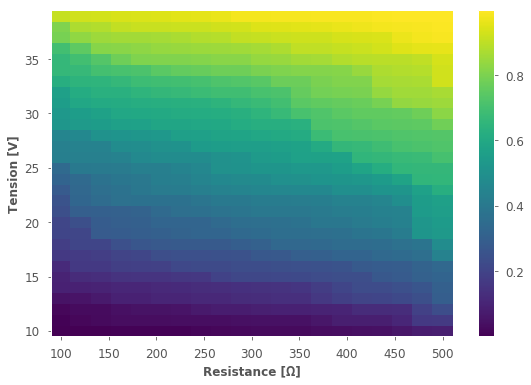

In [3]:
with plt.style.context('ggplot'):
    arr.plot(figsize=(9,6))

<hr/>
# Interpolation with xarray, scipy and sdf

In [4]:
def check_args(func):
    """
    A simple decorator for checking that only two parameters
    are received"""
    def wrapper(*args):
        assert len(args) == 2, "Please provide only 2 parameters for interpolation on arr"
        assert type(args[0]) == type(args[1]), "Please provide parameters of the same type"
        return func(*args)
    return wrapper

**xarray**

In [5]:
@check_args
def xarray_interp(*args):
    return arr.interp({'tension': args[0], 'resistance': args[1]})

In [6]:
%timeit xarray_interp(10.2, 120.4)

6.45 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**scipy**

In [7]:
@check_args
def scipy_interp(*args):
    return interpn([arr.coords[c].data for c in arr.coords], arr.data, (args[0], args[1]))

In [8]:
%timeit scipy_interp(10.2, 120.4)

794 µs ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**sdf**

In [9]:
@check_args
def sdf_interp(*args):
    return arr.interpolate(args[0], args[1])

In [10]:
%timeit sdf_interp(10.2, 120.4)

862 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<hr/>

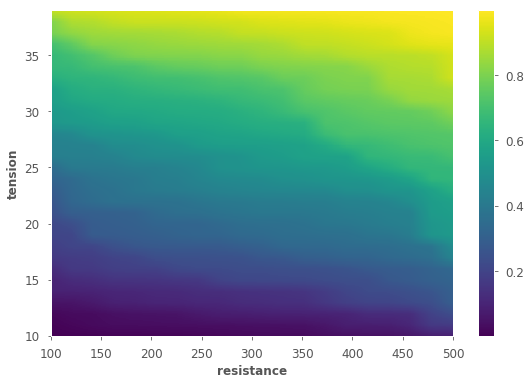

In [23]:
with plt.style.context('ggplot'):
    xarray_interp(np.sort(arr.tension[0].data + np.random.random_sample(size=1000) * (arr.tension[-1].data - arr.tension[0].data)),
                  np.sort(arr.resistance[0].data + np.random.random_sample(size=1000) * (arr.resistance[-1].data - arr.resistance[0].data))).plot(figsize=(9,6))

# Nano bench on 2D-array: SDF, scipy, xarray interpolation

In [11]:
res = {'xarray': [], 'scipy' : [], 'c_sdf' : []}

interpolation_size = np.logspace(1, 3, num=10, dtype=np.int64)

for size in interpolation_size:
    new_tension = arr.tension[0].data + np.random.random_sample(size=size) * (arr.tension[-1].data - arr.tension[0].data)
    new_resistance = arr.resistance[0].data + np.random.random_sample(size=size) * (arr.resistance[-1].data - arr.resistance[0].data)

    x, y = [a.ravel() for a in np.meshgrid(new_tension, new_resistance)]

    # scipy
    res_scipy = %timeit -qo scipy_interp(x, y)
    res['scipy'].append(res_scipy)
    
    # xarray
    res_xr = %timeit -qo xarray_interp(new_tension, new_resistance)
    res['xarray'].append(res_xr)

    # assert that interpolated values from xarray are alsmost equal to scipy
    # np.testing.assert_almost_equal(xarray_interp(new_tension, new_resistance).data,
    #                                scipy_interp(x, y).reshape(size,size).T,
    #                                err_msg=f"xarray vs scipy comparison failed for n={size}")
    
    # sdf
    res_c_sdf = %timeit -qo sdf_interp(x, y)
    res['c_sdf'].append(res_c_sdf)
    
    # assert that interpolated values from sdf are alsmost equal to scipy
    # np.testing.assert_almost_equal(sdf_interp(x, y),
    #                                scipy_interp(x, y),
    #                                err_msg=f"sdf vs scipy comparison failed for n={size}")
    

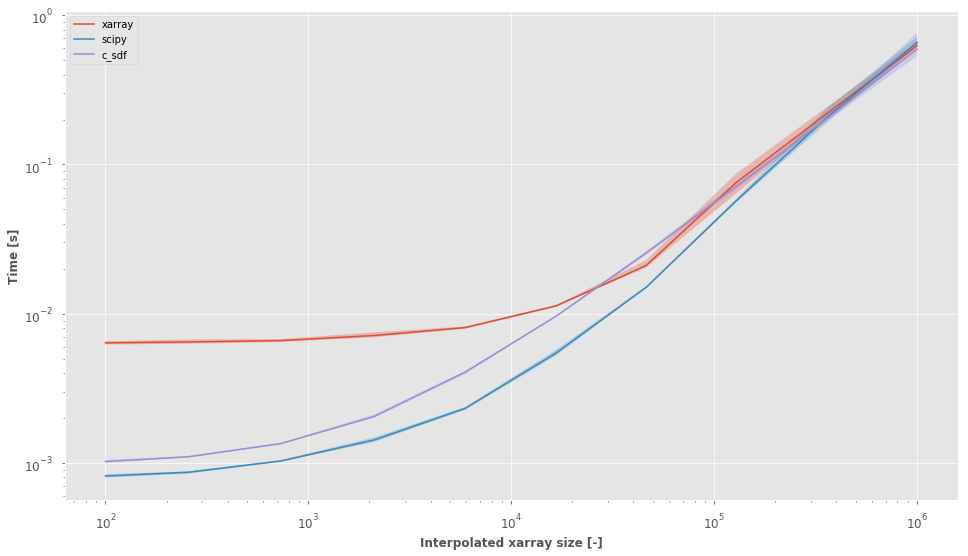

In [12]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(16,9))
    fig.add_subplot(111, xlabel="Interpolated xarray size [-]", ylabel="Time [s]", xscale='log', yscale='log')
    
    for k in res:
        plt.plot(interpolation_size ** 2, [t.average for t in res[k]], label=k)
        plt.fill_between(interpolation_size ** 2, [t.best for t in res[k]], [t.worst for t in res[k]], alpha=0.3)

    plt.legend(loc=2)

# Advanced interpolation

http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation

In [13]:
arr

<xarray.DataArray (tension: 30, resistance: 20)>
array([[8.188761e-05, 2.688065e-03, 3.532211e-03, ..., 5.893948e-02,
        7.914896e-02, 8.482228e-02],
       [5.545408e-03, 1.612921e-02, 2.524236e-02, ..., 1.059085e-01,
        1.655600e-01, 1.710818e-01],
       [1.639248e-02, 2.754293e-02, 2.931972e-02, ..., 1.269580e-01,
        1.942230e-01, 2.326864e-01],
       ...,
       [7.922993e-01, 8.327162e-01, 8.524495e-01, ..., 9.710461e-01,
        9.826226e-01, 9.883285e-01],
       [8.040264e-01, 8.754568e-01, 8.827130e-01, ..., 9.835216e-01,
        9.882149e-01, 9.924784e-01],
       [9.121321e-01, 9.251325e-01, 9.319321e-01, ..., 9.953585e-01,
        9.960863e-01, 9.989184e-01]])
Coordinates:
  * tension     (tension) int64 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 ...
  * resistance  (resistance) float64 100.0 121.1 142.1 163.2 184.2 205.3 ...

In [14]:
tension = xr.DataArray([12.45, 16.67, 19.9934, 45.9], dims="special_case")
resistance = xr.DataArray([234.4, 256.8, 309, 452.738], dims="special_case")

In [15]:
arr.interp(tension=tension, resistance=resistance)

<xarray.DataArray (special_case: 4)>
array([0.079231, 0.239153, 0.361245,      nan])
Coordinates:
    tension     (special_case) float64 12.45 16.67 19.99 45.9
    resistance  (special_case) float64 234.4 256.8 309.0 452.7
Dimensions without coordinates: special_case

<hr/>
Same bench result as above

In [16]:
res = {'xarray': [], 'scipy' : [], 'c_sdf' : []}

interpolation_size = np.logspace(1, 4, num=10, dtype=np.int64)

for size in interpolation_size:
    new_tension = xr.DataArray(arr.tension[0].data + np.random.random_sample(size=size) * (arr.tension[-1].data - arr.tension[0].data), dims="bench")
    new_resistance = xr.DataArray(arr.resistance[0].data + np.random.random_sample(size=size) * (arr.resistance[-1].data - arr.resistance[0].data), dims="bench")

    # scipy
    res_scipy = %timeit -qo scipy_interp(new_tension, new_resistance)
    res['scipy'].append(res_scipy)
    
    # xarray
    res_xr = %timeit -qo arr.interp(tension=new_tension, resistance=new_resistance)
    res['xarray'].append(res_xr)

    # sdf
    res_c_sdf = %timeit -qo sdf_interp(new_tension, new_resistance)
    res['c_sdf'].append(res_c_sdf)

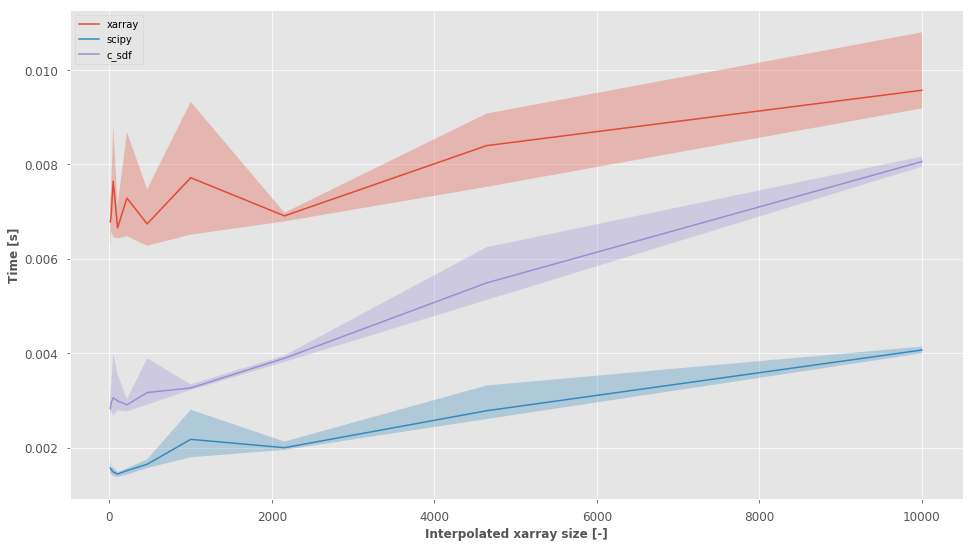

In [17]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(16,9))
    fig.add_subplot(111, xlabel="Interpolated xarray size [-]", ylabel="Time [s]")
    
    for k in res:
        plt.plot(interpolation_size, [t.average for t in res[k]], label=k)
        plt.fill_between(interpolation_size, [t.best for t in res[k]], [t.worst for t in res[k]], alpha=0.3)

    plt.legend(loc=2)

# SDF wrapper

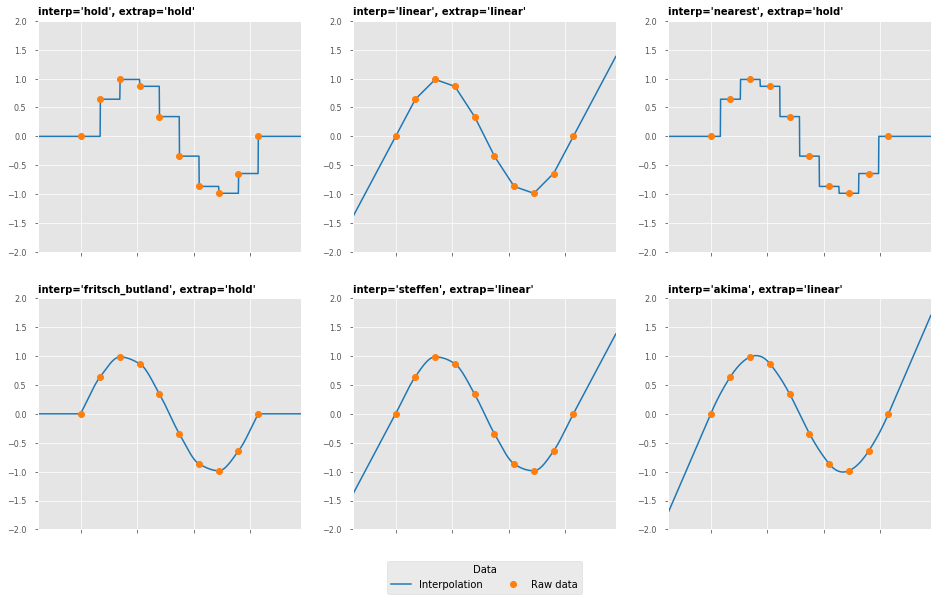

In [18]:
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x)
xi = np.linspace(-1.5,  2 * np.pi + 1.5, 1000)
dxi = np.ones_like(xi)

m2d = xr.DataArray(data=y, coords=[('x', x)])

methods = [('hold', 'hold'),
           ('linear', 'linear'), 
           ('nearest', 'hold'),
           ('fritsch_butland', 'hold'), 
           ('steffen', 'linear'), 
           ('akima', 'linear')]

with plt.style.context('ggplot'):
    mpl.rc('axes', prop_cycle=mpl.cycler('color', mpl.cm.get_cmap("tab10").colors))
    fig = plt.figure(figsize=(16,9),
                     subplotpars=SubplotParams(top=0.91, hspace=0.2))

    for i, method in enumerate(methods):
        ax = fig.add_subplot(2, 3, i + 1,
                             title=f"interp='{method[0]}', extrap='{method[1]}'",
                             xlim=[-1.5, 2 * np.pi + 1.5], ylim=[-2, 2], label="what"
                             )
        ax.title.set_position((0, 1))
        ax.title.set_horizontalalignment('left')
        ax.title.set_fontsize(10)
        ax.title.set_fontweight('bold')
        ax.xaxis.units = 'V'
        ax.xaxis.name = 'Tension'
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.tick_params("y", labelsize=8)
        
        yi = m2d(xi, interp=method[0], extrap=method[1])       
        ax.plot(xi, yi, m2d.x, m2d.data, 'o')
        
    plt.gcf().axes[4].legend(["Interpolation", "Raw data"], bbox_to_anchor=(0, -0.3, 1., 0.1),
               loc=8, ncol=2, mode="normal", borderaxespad=0.5, title="Data")